In [175]:
# 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import math
import os
import sys
import dlib
import csv
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
# INFO, WARNING, and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.getcwd() # working directory

'C:\\Users\\pendr\\cs271_local\\271_project'

Facial Landmark Detection: use landmark provided dlib official

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [5]:
img_rd = cv2.imread("example_face.jpg")
img_gray = cv2.cvtColor(img_rd, cv2.COLOR_RGB2GRAY)

In [6]:
faces = detector(img_gray, 0)

In [7]:
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(len(faces)):
    landmarks = np.matrix([[p.x, p.y] for p in predictor(img_rd, faces[0]).parts()])
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.circle(img_rd, pos, 2, color=(139, 0, 0))

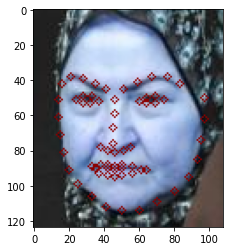

In [8]:
plt.imshow(img_rd)

In [9]:
train_pairs = pd.read_csv("train-pairs.csv")

In [83]:
# generate 68 features
for i in range(0, train_pairs.shape[0]):
    pair = train_pairs.iloc[i,]
    p1 = pair['p1']
    p2 = pair['p2']
    ptype = pair['ptype']
    fid1 = pair['fid1']
    fid2 = pair['fid2']
    pid1 = p1.split("/")[1]
    pid2 = p2.split("/")[1]
    tags = pair['tags']
    set = pair['set']
    nsamples = pair['nsamples']
    p1_files = os.listdir(os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid1)
    p2_files = os.listdir(os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid2)
    for i in range(0, len(p1_files)):
        p1_face = p1_files[i]
        if(p1_face.endswith('jpg')):
            face_img_1 = cv2.imread("train-faces/" + fid1 + "/" + pid1 + "/" + p1_face)
            feature_68_x = []
            feature_68_y = []
            for p in predictor(face_img_1, faces[0]).parts():
                feature_68_x.append(p.x)
                feature_68_y.append(p.y)
            if(os.path.exists("train-faces/" + fid1 + "/" + pid1 + "/" + p1_face.replace('.jpg', '') + "_68.csv") == False):
                with open("train-faces/" + fid1 + "/" + pid1 + "/" + p1_face.replace('.jpg', '') + "_68.csv", 'w') as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(feature_68_x, feature_68_y))
    for i in range(0, len(p2_files)):
        p2_face = p2_files[i]
        if(p2_face.endswith('jpg')):
            face_img_2 = cv2.imread("train-faces/" + fid2 + "/" + pid2 + "/" + p2_face)
            feature_68_x = []
            feature_68_y = []
            for p in predictor(face_img_2, faces[0]).parts():
                feature_68_x.append(p.x)
                feature_68_y.append(p.y)
            if(os.path.exists("train-faces/" + fid2 + "/" + pid2 + "/" + p2_face.replace('.jpg', '') + "_68.csv") == False):
                with open("train-faces/" + fid2 + "/" + pid2 + "/" + p2_face.replace('.jpg', '') + "_68.csv", 'w') as f:
                    writer = csv.writer(f)
                    writer.writerows(zip(feature_68_x, feature_68_y))

Average Face Creation Function
Reference: https://learnopencv.com/average-face-opencv-c-python-tutorial/

Copyright (c) 2016 Satya Mallick <spmallick@learnopencv.com>

In [187]:
# Read points from 68 files in directory
def readPoints(path) :
    # Create an array of array of points.
    pointsArray = []
    
    #List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
        
        if filePath.endswith(".csv"):
            
            #Create an array of points.
            points = []
            
            # Read points from filePath
            csv_68 = pd.read_csv(os.path.join(path, filePath), header = None)
            for i in range(0,csv_68.shape[0]):
                x = csv_68.iloc[i, 0]
                y = csv_68.iloc[i, 1]
                points.append((int(x), int(y)))
            
            # Store array of points
            pointsArray.append(points)
    return pointsArray

In [188]:
# Read all jpg images in folder.
def readImages(path) :
    
    #Create array of array of images.
    imagesArray = []
    
    #List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
       
        if filePath.endswith(".jpg"):
            # Read image found.
            img = cv2.imread(os.path.join(path,filePath))

            # Convert to floating point
            img = np.float32(img)/255.0

            # Add to array of images
            imagesArray.append(img)
            
    return imagesArray

In [189]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.

def similarityTransform(inPoints, outPoints) :
    s60 = math.sin(60*math.pi/180)
    c60 = math.cos(60*math.pi/180)  
  
    inPts = np.copy(inPoints).tolist()
    outPts = np.copy(outPoints).tolist()
    
    xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
    yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]
    
    inPts.append([np.int(xin), np.int(yin)])

    xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
    yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]
    
    outPts.append([np.int(xout), np.int(yout)])
    
    tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
    
    return tform[0]

In [190]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[2] :
        return False
    elif point[1] > rect[3] :
        return False
    return True

In [191]:
# Calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    # Create subdiv
    subdiv = cv2.Subdiv2D(rect)
   
    # Insert points into subdiv
    for p in points:
        subdiv.insert((p[0], p[1]))

   
    # List of triangles. Each triangle is a list of 3 points ( 6 numbers )
    triangleList = subdiv.getTriangleList()

    # Find the indices of triangles in the points array

    delaunayTri = []
    
    for t in triangleList:
        pt = []
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)                            
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        

    
    return delaunayTri

In [192]:
def constrainPoint(p, w, h) :
    p =  ( min( max( p[0], 0 ) , w - 1 ) , min( max( p[1], 0 ) , h - 1 ) )
    return p

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

In [193]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect


In [194]:
def generate_avg_face(path):
    
    # Dimensions of output image
    w = 600
    h = 600

    # Read points for all images
    allPoints = readPoints(path)
    
    # Read all images
    images = readImages(path)
    
    # Eye corners
    eyecornerDst = [ (np.int(0.3 * w ), np.int(h / 3)), (np.int(0.7 * w ), np.int(h / 3)) ]
    
    imagesNorm = []
    pointsNorm = []
    
    # Add boundary points for delaunay triangulation
    boundaryPts = np.array([(0,0), (w/2,0), (w-1,0), (w-1,h/2), ( w-1, h-1 ), ( w/2, h-1 ), (0, h-1), (0,h/2) ])
    
    # Initialize location of average points to 0s
    pointsAvg = np.array([(0,0)]* ( len(allPoints[0]) + len(boundaryPts) ), np.float32())
    
    n = len(allPoints[0])

    numImages = len(images)
    # Warp images and trasnform landmarks to output coordinate system,
    # and find average of transformed landmarks.
    
    for i in range(0, numImages):
        points1 = allPoints[i]

        # Corners of the eye in input image
        eyecornerSrc  = [ allPoints[i][36], allPoints[i][45] ] 
        
        # Compute similarity transform
        tform = similarityTransform(eyecornerSrc, eyecornerDst)
        
        # Apply similarity transformation
        img = cv2.warpAffine(images[i], tform, (w,h))

        # Apply similarity transform on points
        points2 = np.reshape(np.array(points1), (68,1,2))
        
        points = cv2.transform(points2, tform)
        
        points = np.float32(np.reshape(points, (68, 2)))
        
        # Append boundary points. Will be used in Delaunay Triangulation
        points = np.append(points, boundaryPts, axis=0)
        
        # Calculate location of average landmark points.
        pointsAvg = pointsAvg + points / numImages
        
        pointsNorm.append(points)
        imagesNorm.append(img)
    

    
    # Delaunay triangulation
    rect = (0, 0, w, h)
    dt = calculateDelaunayTriangles(rect, np.array(pointsAvg))

    # Output image
    output = np.zeros((h,w,3), np.float32())

    # Warp input images to average image landmarks
    for i in range(0, len(imagesNorm)) :
        img = np.zeros((h,w,3), np.float32())
        # Transform triangles one by one
        for j in range(0, len(dt)) :
            tin = []
            tout = []
            
            for k in range(0, 3) :                
                pIn = pointsNorm[i][dt[j][k]]
                pIn = constrainPoint(pIn, w, h)
                
                pOut = pointsAvg[dt[j][k]]
                pOut = constrainPoint(pOut, w, h)
                
                tin.append(pIn)
                tout.append(pOut)
            
            
            warpTriangle(imagesNorm[i], img, tin, tout)


        # Add image intensities for averaging
        output = output + img


    # Divide by numImages to get average
    output = output / numImages

    # Display result
    return output

Generate average face

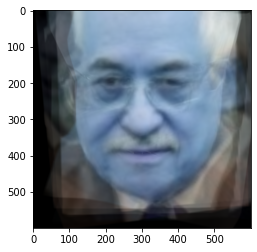

In [195]:
# Sample Face
for i in range(0, 1):
    pair = train_pairs.iloc[i,]
    p1 = pair['p1']
    p2 = pair['p2']
    ptype = pair['ptype']
    fid1 = pair['fid1']
    fid2 = pair['fid2']
    pid1 = p1.split("/")[1]
    pid2 = p2.split("/")[1]
    tags = pair['tags']
    set = pair['set']
    nsamples = pair['nsamples']
    p1_path = os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid1
    p2_path = os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid2
    try:
        avg_face_1 = generate_avg_face(p1_path)
        avg_face_2 = generate_avg_face(p2_path)
        plt.imshow(avg_face_1)
    except Exception as e:
        print(e)

In [92]:
F_files = os.listdir(os.getcwd() + "\\train-faces")

In [95]:
for i in range(0, train_pairs.shape[0]):
    pair = train_pairs.iloc[i,]
    p1 = pair['p1']
    p2 = pair['p2']
    ptype = pair['ptype']
    fid1 = pair['fid1']
    fid2 = pair['fid2']
    pid1 = p1.split("/")[1]
    pid2 = p2.split("/")[1]
    tags = pair['tags']
    set = pair['set']
    nsamples = pair['nsamples']
    p1_path = os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid1
    p2_path = os.getcwd() + "\\train-faces\\" + fid1 + "\\" + pid2
    try:
        avg_face_1 = generate_avg_face(p1_path)
        avg_face_2 = generate_avg_face(p2_path)
    
        path = os.getcwd() + "\\avg_faces\\" + fid1
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)

        path = os.getcwd() + "\\avg_faces\\" + fid2
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)

        path = os.getcwd() + "\\avg_faces\\" + fid1 + "\\" + pid1
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)

        path = os.getcwd() + "\\avg_faces\\" + fid2 + "\\" + pid2
        isExist = os.path.exists(path)
        if not isExist:
          os.makedirs(path)

        cv2.imwrite(os.getcwd() + "\\avg_faces\\" + fid1 + "\\" + pid1 + "\\" + "avg.jpg", 255*avg_face_1)
        cv2.imwrite(os.getcwd() + "\\avg_faces\\" + fid1 + "\\" + pid2 + "\\" + "avg.jpg", 255*avg_face_2)
    except Exception as e:
        print(e)

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\op

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\op

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix.cpp:466: error: (-215:Assertion failed) _step >= minstep in function 'cv::Mat::Mat'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix.cpp:466: error: (-215:Assertion failed) _step >= minstep in function 'cv::Mat::Mat'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288: error: (-211:One of the arguments' values is out of range)  in function 'cv::Subdiv2D::locate'

OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\subdivision2d.cpp:288

[1 - same generation]
bb brother - brother
ss sister - sister
sibs sibilings

[2 - 1st generation]
fd father-daughter
fs father-son
md mother-daughter
ms mother-son

[0 - no kinship]

In [60]:
# function that generates train data 
def generate_train_data(df_train,cutoff=None):
    old_dir=os.getcwd()
    os.chdir(r'avg_faces')

    X1,X2,y=[],[],[]
    related=set()
    
    # add traning data with kinship
    for i in tqdm(range(len(df_train))[:cutoff]):
        img1=df_train.iloc[i,0];img2=df_train.iloc[i,1]
        related.add((img1,img2));related.add((img2,img1))
        
        path_1 = os.path.join(img1,"avg.jpg")
        path_2 = os.path.join(img2,"avg.jpg")
        
        exist_1 = os.path.exists(path_1)
        exist_2 = os.path.exists(path_2)
        
        if (exist_1 and exist_2):
            img1=path_1
            img2=path_2
            img1=cv2.imread(img1);img2=cv2.imread(img2)
            img1=cv2.resize(img1,(160,160));img2=cv2.resize(img2,(160,160))
            ptype = df_train.iloc[i,2]
            if(ptype == "bb" or ptype == "ss" or ptype == "sibs"):
                X1.append(img1);X2.append(img2)
                y.append(1)
            elif(ptype == "fd" or ptype == "fs" or ptype == "md" or ptype == "ms"):
                X1.append(img1);X2.append(img2)
                y.append(2)
    
    # add traning data without kinship
    for i in tqdm(range(len(df_train))[:cutoff]):
        try:
            img1=choose_img();img2=choose_img()
            while (img1,img2) in related or len(os.listdir(img1))==0 or len(os.listdir(img2))==0:
                img1=choose_img();img2=choose_img() # randomly choose two individuals who do not have kinship relations

            path_1 = os.path.join(img1,"avg.jpg")
            path_2 = os.path.join(img2,"avg.jpg")

            exist_1 = os.path.exists(path_1)
            exist_2 = os.path.exists(path_2)
            
            if (exist_1 and exist_2):
                img1=path_1
                img2=path_2
                img1=cv2.imread(img1);img2=cv2.imread(img2)
                img1=cv2.resize(img1,(160,160));img2=cv2.resize(img2,(160,160))
                X1.append(img1);X2.append(img2)
                y.append(0)
        except Exception as e:
            continue;

    X1=np.array(X1);X2=np.array(X2);y=np.array(y)

    os.chdir(old_dir)

    return X1,X2,y

In [61]:
# documentation here
def choose_img(verbose=False):
    # assume called in data/train-faces|
    family=np.random.choice(os.listdir())
    individual=''
    while not(len(individual)>3 and individual[:3]=='MID'):
        individual=np.random.choice(os.listdir(family))
    img=family+'/'+individual
    if verbose:
        print(img)
    return img

In [65]:
X1,X2,y=generate_train_data(train_pairs)
print(X1.shape);print(X2.shape);print(y.shape)

100%|██████████| 6983/6983 [01:05<00:00, 105.99it/s]


(13368, 160, 160, 3)
(13368, 160, 160, 3)
(13368,)


In [66]:
from sklearn.model_selection import train_test_split
X1_train,X1_test,X2_train,X2_test,y_train,y_test=train_test_split(X1,X2,y,test_size=0.2,random_state=42)

In [67]:
import keras
from keras.layers import Input,Dense,Concatenate,Dropout
from keras.models import load_model

In [71]:
inp1=Input(name='inp1',shape=(160,160,3));inp2=Input(name='inp2',shape=(160,160,3))
backbone=load_model('models\\facenet_keras.h5')
fc1=backbone(inp1);fc2=backbone(inp2)
fc=Concatenate(axis=-1)([fc1,fc2])
fc=Dense(128,activation='relu')(fc)
fc=Dropout(0.5)(fc)
fc=Dense(3,activation='softmax')(fc)
model=keras.Model(inputs=[inp1,inp2],outputs=fc)

# compile model
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# fit model
model.fit([X1_train,X2_train],y_train,
        validation_data=([X1_test, X2_test], y_test),
        epochs=10,batch_size=64,verbose=1)

Train on 10694 samples, validate on 2674 samples
Epoch 1/10
10694/10694 [==============================] - 5671s 530ms/step - loss: 0.8758 - acc: 0.6123 - val_loss: 0.8748 - val_acc: 0.6447
Epoch 2/10
10694/10694 [==============================] - 5206s 487ms/step - loss: 0.6112 - acc: 0.7257 - val_loss: 0.6512 - val_acc: 0.6889
Epoch 3/10
10694/10694 [==============================] - 5205s 487ms/step - loss: 0.5029 - acc: 0.7814 - val_loss: 0.6317 - val_acc: 0.7072
Epoch 4/10
10694/10694 [==============================] - 5191s 485ms/step - loss: 0.4720 - acc: 0.7998 - val_loss: 0.5376 - val_acc: 0.7625
Epoch 5/10
10694/10694 [==============================] - 5141s 481ms/step - loss: 0.4150 - acc: 0.8245 - val_loss: 0.5087 - val_acc: 0.7996
Epoch 6/10
10694/10694 [==============================] - 5062s 473ms/step - loss: 0.3586 - acc: 0.8590 - val_loss: 0.4542 - val_acc: 0.8123
Epoch 7/10
10694/10694 [==============================] - 5064s 474ms/step - loss: 0.3414 - acc: 0.8617 -

In [72]:
# save model
model.save('facenet_baseline1203.h5')

In [73]:
# load model
model=load_model('facenet_baseline1203.h5')

prediction on internal test data

In [160]:
pred_test= model.predict([X1_test, X2_test])
scores2 = model.evaluate([X1_test, X2_test], y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on test data: 0.8059087508011863% 
 Error on test data: 0.1940912491988137


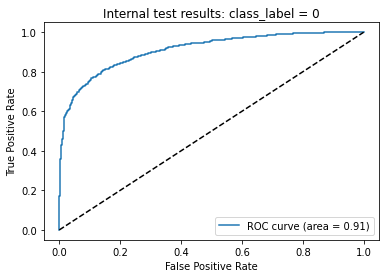

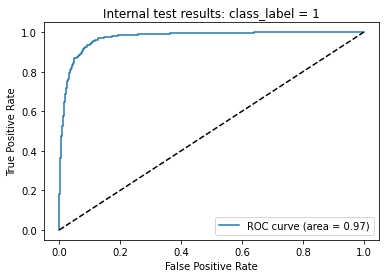

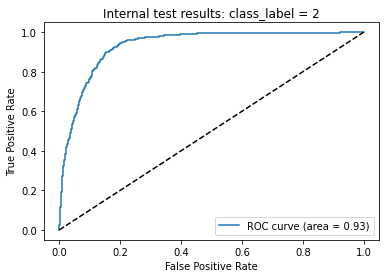

In [184]:
from sklearn import preprocessing
y_test_binarized = preprocessing.label_binarize(y_test, classes=[0, 1, 2])
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Internal test results: class_label = '+ str(i))
    plt.legend(loc="lower right")
    plt.show()

prediction on validation data

In [162]:
val_pairs = pd.read_csv("train-pairs-updated.csv")
X1_val,X2_val,y_val=generate_train_data(val_pairs)
print(X1_val.shape);print(X2_val.shape);print(y_val.shape)

100%|██████████| 6983/6983 [01:11<00:00, 97.01it/s] 


(13356, 160, 160, 3)
(13356, 160, 160, 3)
(13356,)


In [183]:
pred_test_val = model.predict([X1_val, X2_val])
scores2_val = model.evaluate([X1_val, X2_val], y_val, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2_val[1], 1 - scores2_val[1]))  

Accuracy on test data: 0.8352800239414182% 
 Error on test data: 0.1647199760585818


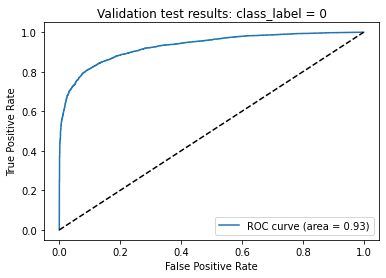

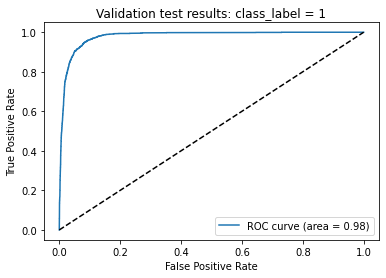

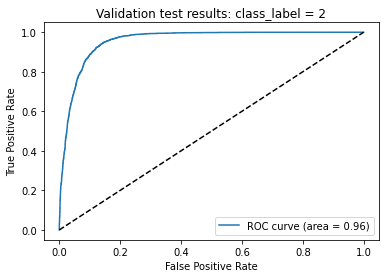

In [185]:
from sklearn import preprocessing
y_val_binarized = preprocessing.label_binarize(y_val, classes=[0, 1, 2])
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], pred_test_val[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Validation test results: class_label = '+ str(i))
    plt.legend(loc="lower right")
    plt.show()

In [196]:
df_test = r'test_competition.csv'
df_test = pd.read_csv(df_test)
df_test.head()

,index,p1,p2,ptype
0,0,face3118.jpg,face322.jpg,bb
1,1,face1058.jpg,face322.jpg,bb
2,2,face1859.jpg,face2895.jpg,bb
3,3,face4234.jpg,face2895.jpg,bb
4,4,face4234.jpg,face322.jpg,bb


In [197]:
df_test = df_test[df_test['ptype'].isin(['bb','fs','md','fd','ss','ms','sibs'])]

In [198]:
df_test['prediction'] = -1
df_test['y'] = 0

In [199]:
df_test.loc[df_test['ptype'].isin(['bb','ss','sibs']),'y'] = 1

In [200]:
df_test.loc[df_test['ptype'].isin(['fs','md','fd','ms']),'y'] = 2

test 1: 100 random examples from test data

In [201]:
df_test_sample_1 = df_test.sample(n = 100)

In [ ]:
correct,count=0,0
for idx, row in tqdm(df_test_sample_1.iterrows(),desc='scoring test set'):
    img1=cv2.imread(os.path.join(r'test-faces',row['p1']))
    img2=cv2.imread(os.path.join(r'test-faces',row['p2']))
    try:
        img1=cv2.resize(img1,(160,160))
        img2=cv2.resize(img2,(160,160))
        x1=np.expand_dims(img1,axis=0)
        x2=np.expand_dims(img2,axis=0)
        pred=np.argmax(model.predict([x1,x2]))
        df_test_sample_1.iloc[count, -2] = pred
    except Exception as e:   
        print(str(e))
    count+=1

scoring test set: 5it [00:02,  1.70it/s]

In [148]:
same_generation_correct = df_test_sample_1[(df_test_sample_1.prediction == 1) & (df_test_sample_1.y == 1)].count()[0]
same_generation_total = df_test_sample_1[df_test_sample_1.y == 1].count()[0]
print("Same generation precision: ",same_generation_correct/same_generation_total)

Same generation precision:  0.36363636363636365


In [149]:
one_generation_correct = df_test_sample_1[(df_test_sample_1.prediction == 2) & (df_test_sample_1.y == 2)].count()[0]
one_generation_total = df_test_sample_1[df_test_sample_1.y == 2].count()[0]
print("Same generation precision: ",one_generation_correct/one_generation_total)

Same generation precision:  0.4634146341463415


In [151]:
correct = df_test_sample_1[df_test_sample_1.prediction == df_test_sample_1.y].count()[0]
total = 200
print("precision: ",correct/total)

precision:  0.425


In [ ]:
print("Same generation recall: ",df_test_sample_1[df_test_sample_1.prediction == 1].count()[0]/df_test_sample_1[df_test_sample_1.y == 1].count()[0])